Pole balancing

RL Based on:  
<https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>

Recurrent DQN based on:  
<https://arxiv.org/pdf/1507.06527.pdf>

In [13]:
import math
import numbers
import random
import collections
from collections import namedtuple, deque
import itertools
import pprint

pp = pprint.PrettyPrinter()

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchinfo

import utility as util

env = gym.make('CartPole-v0').unwrapped

In [2]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=T.InterpolationMode.BICUBIC),
                    T.ToTensor()])

In [14]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = util.AttrDict(
        episodes=2_000,
        minibatch_size=64,
        multistep_size=20,
        discount=0.999,
        eps_start=0.9,
        eps_end=0.05,
        eps_decay=0.9995,
        update_target_interval=10,
        replay_memory_minlen=200,
        replay_memory_maxlen=10_000,
        aggregate_stats_interval=50)

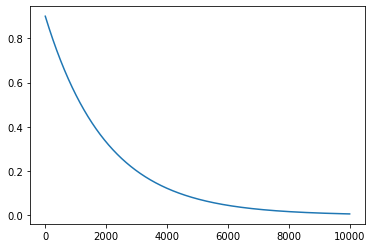

In [15]:
n = 10_000
l = [None]*n
l[0] = config.eps_start
for i in range(1, n):
    l[i] = l[i - 1]*config.eps_decay
plt.plot(np.arange(10_000), l)

In [16]:
# Transitions and Replay Memory
Transition = namedtuple('Transition',
                        ('curr_state', 'action', 'next_state', 'reward', 'is_done'))

class ReplayMemory(object):

    def __init__(self, capacity, transition=Transition):
        self.__episode_to_frames = collections.OrderedDict()
        self.__n_frames = 0
        self.__capacity = capacity
        self.__transition = transition

    def add(self, episode, tuple_args):
        """Save a transition.
        Assumes that the number of frames << capacity.
        """
        if episode in self.__episode_to_frames:
            self.__episode_to_frames[episode].append(self.__transition(*tuple_args))
        else:
            self.__episode_to_frames[episode] = [self.__transition(*tuple_args)]
        self.__n_frames += 1
        if self.__n_frames > self.__capacity:
            _episode, _frames = self.__episode_to_frames.popitem(last=False)
            self.__n_frames -= len(_frames)

    def __f(self, frames):
        return self.__transition(*[ torch.stack(x) for x in zip(*frames) ])
            
    def sample(self, batch_size, steps):
        # choice_episodes_frames is a batch_size sized list of (list of Transition)
        choice_episodes_frames = random.choices(
                list(self.__episode_to_frames.values()), k=batch_size)
        # start_indices is a batch_size sized list of int 
        start_indices = [
                random.randrange(0, max(len(val) - steps + 1, 1)) for val in choice_episodes_frames]
        choice_episodes_frames = [
                choice_episodes_frames[idx][start_idx:start_idx+steps] \
                    for idx, start_idx in enumerate(start_indices)]
        return [self.__f(_frames) for _frames in choice_episodes_frames]

    def __len__(self):
        return self.__n_frames

In [14]:
# Test ReplayMemory
_Transition = namedtuple('A',
                        ('a', 'b'))
memory = ReplayMemory(10, transition=_Transition)
inputs = torch.arange(10).reshape(-1,2)
for input in inputs:
    memory.add(1, input)
inputs = torch.arange(10, 20).reshape(-1,2)
for input in inputs:
    memory.add(2, input)
pp.pprint(memory.sample(3, 3))
pp.pprint(memory._ReplayMemory__episode_to_frames)
inputs = torch.arange(20, 26).reshape(-1,2)
for input in inputs:
    memory.add(3, input)
pp.pprint(memory._ReplayMemory__episode_to_frames)

[A(a=tensor([0, 2, 4]), b=tensor([1, 3, 5])),
 A(a=tensor([10, 12, 14]), b=tensor([11, 13, 15])),
 A(a=tensor([14, 16, 18]), b=tensor([15, 17, 19]))]
OrderedDict([(1,
              [A(a=tensor(0), b=tensor(1)),
               A(a=tensor(2), b=tensor(3)),
               A(a=tensor(4), b=tensor(5)),
               A(a=tensor(6), b=tensor(7)),
               A(a=tensor(8), b=tensor(9))]),
             (2,
              [A(a=tensor(10), b=tensor(11)),
               A(a=tensor(12), b=tensor(13)),
               A(a=tensor(14), b=tensor(15)),
               A(a=tensor(16), b=tensor(17)),
               A(a=tensor(18), b=tensor(19))])])
OrderedDict([(2,
              [A(a=tensor(10), b=tensor(11)),
               A(a=tensor(12), b=tensor(13)),
               A(a=tensor(14), b=tensor(15)),
               A(a=tensor(16), b=tensor(17)),
               A(a=tensor(18), b=tensor(19))]),
             (3,
              [A(a=tensor(20), b=tensor(21)),
               A(a=tensor(22), b=tensor(23)),
   

In [9]:
# Some attributes of Gym environment
# Reward is 1 for every step taken, including the termination step

print("Environment attributes:", *vars(env).keys())
print("Gravitational constant:", env.gravity)
print("Number of possible actions an agent can make:", env.action_space.n)
print("Sampling of discrete action space gives:", env.action_space.sample())
# The (observation) state is an array
# [Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity]
print("Current state is:", env.state)
print("States are bounded below by:", env.observation_space.low)
print("States are bounded above by:",env.observation_space.high)
# help(env.observation_space)
# help(env) # for more information

Environment attributes: gravity masscart masspole total_mass length polemass_length force_mag tau kinematics_integrator theta_threshold_radians x_threshold action_space observation_space np_random viewer state steps_beyond_done spec
Gravitational constant: 9.8
Number of possible actions an agent can make: 2
Sampling of discrete action space gives: 0
Current state is: None
States are bounded below by: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
States are bounded above by: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


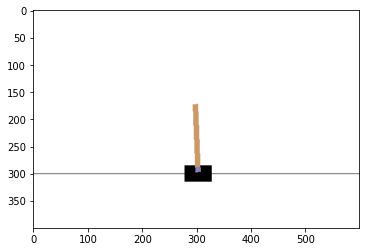

In [47]:
# Getting the first snapshot of the environment after resetting the Gym 
env.reset()
screen = env.render(mode='rgb_array')
plt.imshow(screen)

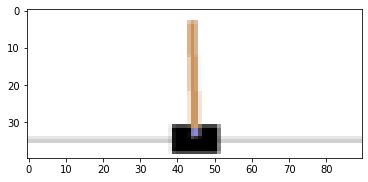

In [68]:
def get_cart_location(env, screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def preprocess_screen(env, screen):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = screen.transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(env, screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

def render(env):
    return env.render(mode='rgb_array')

env.reset()
screen = render(env)
screen = preprocess_screen(env, screen)
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
None

## Using CartPole from PyTorch Tutorial

Based on:
<https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>

In [18]:
class RecurrentDQNet(nn.Module):
    
    def __init__(self, channels, height, width, outputs):
        super().__init__()
        # nn.BatchNorm2d produces nans if the input is a nan since it keeps a moving average
        self.convs = nn.Sequential(*[
                nn.Conv2d(3, 16, kernel_size=5, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=5, stride=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=5, stride=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Flatten()])
        self.lstm = nn.LSTM(512, 128, 1, batch_first=True)
        self.linear = nn.Linear(128, outputs)
        self.__memory = None

    def reset(self):
        self.__memory = None

    def forward(self, x, is_optimizing=False):
        """
        Parameters
        ==========
        x : tensor
            Has shape (batch size, history, channels, height, width)
        is_training : bool
            Is training
        
        Returns
        =======
        tensor
            (batch size, history, actions)
        """
        # for processed CartPole scene
        # x has shape (n_batch, n_history, 3, 40, 90)
        n_batch = x.shape[0]
        n_history = x.shape[1]
        # after passing through convolutions
        # x has shape (n_batch*n_history, 32, 2, 8)
        x = x.reshape(n_batch*n_history, *x.shape[2:])
        x = self.convs(x)
        # x has shape (n_batch, n_history, 512)
        x = x.reshape(n_batch, n_history, -1)
        if is_optimizing:
            x, _ = self.lstm(x)
            # if is_optimizing and self.training: print(h)
        else:
            x, self.__memory = self.lstm(x, self.__memory)
        return self.linear(x)

In [27]:
net = RecurrentDQNet(3, 40, 90, 2)
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(net, input_size=(1, 1, 3, 40, 90), col_names=col_names, col_width=18)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
RecurrentDQNet                           --                 --                 --                 --
├─Sequential: 1-1                        [1, 3, 40, 90]     [1, 512]           --                 --
│    └─Conv2d: 2-1                       [1, 3, 40, 90]     [1, 16, 18, 43]    1,216              [3, 16, 5, 5]
│    └─BatchNorm2d: 2-2                  [1, 16, 18, 43]    [1, 16, 18, 43]    32                 [16]
│    └─ReLU: 2-3                         [1, 16, 18, 43]    [1, 16, 18, 43]    --                 --
│    └─Conv2d: 2-4                       [1, 16, 18, 43]    [1, 32, 7, 20]     12,832             [16, 32, 5, 5]
│    └─BatchNorm2d: 2-5                  [1, 32, 7, 20]     [1, 32, 7, 20]     64                 [32]
│    └─ReLU: 2-6                         [1, 32, 7, 20]     [1, 32, 7, 20]     --                 --
│    └─Conv2d: 2-7                       [1, 32, 7, 20

In [19]:
class RecurrentStateDQNAgent(object):
    """
    Trains a 1-step DQN agent with LSTM using bootstrapped random updates. 
    
    > Episodes are selected randomly from the replay memory and updates 
    > begin at random points in the episode and proceed for only unroll
    > iterations timesteps (e.g. one backward call).
    
    Based on:
    https://arxiv.org/pdf/1507.06527.pdf
    """

    def __update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.terminal_state_counter = 0
    
    def __init__(self, env, config, device):
        self.env      = env
        self.config   = config
        self.device   = device
        self.discount = self.config.discount
        self.eps_end  = self.config.eps_end
        self.eps_start = self.config.eps_start
        self.eps_decay = self.config.eps_decay
        self.epsilon   = self.eps_start
        self.replay_memory_minlen = self.config.replay_memory_minlen
        self.replay_memory_maxlen = self.config.replay_memory_maxlen
        self.update_target_interval = self.config.update_target_interval
        self.multistep_size = self.config.multistep_size
        self.minibatch_size = self.config.minibatch_size
        self.env.reset()
        init_screen = self.render(is_input=True)
        self.n_channels, self.screen_height, self.screen_width = init_screen.shape
        self.n_actions = env.action_space.n
        self.policy_net = RecurrentDQNet(
                self.n_channels, self.screen_height, self.screen_width, self.n_actions).to(self.device)
        self.target_net = RecurrentDQNet(
                self.n_channels, self.screen_height, self.screen_width, self.n_actions).to(self.device)
        self.target_net.eval()
        self.__update_target_model()
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.criterion = nn.SmoothL1Loss()
        self.replay_memory = ReplayMemory(self.replay_memory_maxlen)
        self.steps = 0

    def update_replay_memory(self, episode, tuple_args):
        """
        Adds step's data to a memory replay array
        
        Parameters
        ==========
        transition : tuple
            Contains (curr_state, action, next_state, reward, is_done) where
            - curr_state : or s_t, an RGB image of dimensions (channels, height, width)
            - action     : or a_t, an integer 0-9.
            - next_state : or s_{t+1}, an RGB image of dimensions (channels, height, width)
            - reward     : or r_t, a number
            - is_done    : a boolean specifying whether s_t is a terminal state
                           where the simulation ended.
        """
        self.replay_memory.add(episode, tuple_args)

    def select_action(self, state, is_training=True):
        sample = random.random()
        eps_threshold = self.epsilon
        if is_training:
            self.epsilon = max(self.epsilon*self.eps_decay, self.eps_end)
        if is_training and sample <= eps_threshold:
            return torch.tensor(random.randrange(self.n_actions), device=self.device, dtype=torch.long)
        else:
            self.policy_net.eval()
            with torch.no_grad():
                values, indices = self.policy_net(state.unsqueeze(0).unsqueeze(0)).max(2)
            self.policy_net.train()
            return indices.squeeze()

    def __get_cart_location(self, screen_width):
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        return int(self.env.state[0] * scale + screen_width / 2.0)

    def __preprocess_screen(self, screen):
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        screen = screen.transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = self.__get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        return resize(screen).to(self.device)

    def render(self, is_input=False):
        screen = self.env.render(mode='rgb_array')
        if is_input:
            return self.__preprocess_screen(screen)
        else:
            return screen

    def reset(self):
        self.env.reset()
        self.policy_net.reset()
    
    def __pad_transitions(self, transitions):
        """Pad transitions that are not length multistep_size
        """
        for idx in range(len(transitions)):
            transition = transitions[idx]
            if transition.reward.size(0) < self.multistep_size:
                n_pad_steps = self.multistep_size - transition.reward.size(0)
                pad_tuple = (0,0,0,0,0,0,0,n_pad_steps)
                curr_state = F.pad(transition.curr_state, pad_tuple, mode='constant', value=0.)
                next_state = F.pad(transition.next_state, pad_tuple, mode='constant', value=0.)
                pad_tuple = (0,n_pad_steps)
                is_done = F.pad(transition.is_done, pad_tuple, mode='constant', value=-1)
                action  = F.pad(transition.action,  pad_tuple, mode='constant', value=0)
                reward  = F.pad(transition.reward,  pad_tuple, mode='constant', value=0)
                transitions[idx] = Transition(curr_state, action, next_state, reward, is_done)
    
    def train(self, is_terminal_state=False):
        if len(self.replay_memory) < self.replay_memory_minlen:
            # Start training only if replay memory reached a minimum size
            return None
        # Get minibatch of multi-step transitions
        # transitions is a minibatch_size sized list of Transition
        # transitions[i].{curr_state, next_state}  have shape (5, 3, 40, 90)
        # transitions[i].{reward, action, is_done} have shape (5,)
        transitions = self.replay_memory.sample(
                self.minibatch_size, self.multistep_size)
        self.__pad_transitions(transitions)
        batch = Transition(*zip(*transitions))
        # Compute the current Q values
        # curr_state has shape (minibatch_size, 5, 3, 40, 90)
        curr_states = torch.stack(batch.curr_state)
        # curr_Qs has shape (minibatch_size, 5, 2)
        curr_Qs = self.policy_net(curr_states, is_optimizing=True)
        # Extract the Q values corresponding to agent actions
        # actions has shape (minibatch_size, 5, 1)
        actions = torch.stack(batch.action).unsqueeze(2)
        # curr_Qs, rewards, is_dones have shape (minibatch_size, 5)
        curr_Qs = curr_Qs.gather(2, actions).squeeze(2)
        rewards = torch.stack(batch.reward)
        is_dones = torch.stack(batch.is_done)
        # Compute the max of next Q values
        next_states = torch.stack(batch.next_state)
        with torch.no_grad():
            # print("next_states has nan", torch.isnan(next_states).any())
            # print("next_states", next_states.min(), next_states.max())
            next_Qs = self.target_net(next_states, is_optimizing=True)
            # print("next_Qs has nan", torch.isnan(next_Qs).any())
        # max_next_Qs has shape (minibatch_size, 5)
        max_next_Qs, _ = next_Qs.max(2)
        # Compute the expected Q values for TD error
        expected_Qs = torch.zeros(
                self.minibatch_size, self.multistep_size,
                dtype=torch.float, device=device)
        mask0 = is_dones == 0
        expected_Qs[mask0] = rewards[mask0] + self.discount*max_next_Qs[mask0]
        mask1 = is_dones == 1
        expected_Qs[mask1] = rewards[mask1]
        mask2 = mask0 | mask1
        curr_Qs = curr_Qs[mask2]
        expected_Qs = expected_Qs[mask2]
        # Model training step
        self.optimizer.zero_grad()
        loss = self.criterion(curr_Qs, expected_Qs)
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # Update target model if necessary
        if is_terminal_state:
            self.terminal_state_counter += 1
        if self.terminal_state_counter > self.update_target_interval:
            self.__update_target_model()
        return loss.item()

In [21]:
# test the agent
agent = RecurrentStateDQNAgent(env, config, device)
agent.reset()
curr_state = agent.render(is_input=True)
action = agent.select_action(curr_state, is_training=False)
_, reward, is_done, _ = env.step(action.item())
action, reward, is_done

(tensor(0, device='cuda:0'), 1.0, False)

In [20]:
def recurrent_train(env, config, device):
    agent = RecurrentStateDQNAgent(env, config, device)
    # Reward is 1 for every step taken, including the termination step
    episode_rewards = [0]
    avgs_reward = []
    mins_reward = []
    maxs_reward = []
    for episode in range(1, config.episodes + 1):
        # agent.writer.add_scalar('epsilon', agent.epsilon, episode)
        agent.reset()
        is_done = False
        episode_reward = 0
        episode_losses = []
        curr_state = agent.render(is_input=True)
        next_state = torch.zeros(
                curr_state.shape, dtype=curr_state.dtype, device=device)
        while not is_done:
            action = agent.select_action(curr_state)
            _, reward, is_done, _ = env.step(action.item())
            episode_reward += reward
            if is_done:
                next_state = torch.zeros(
                        curr_state.shape, dtype=curr_state.dtype, device=device)
            else:
                next_state = agent.render(is_input=True)
            agent.update_replay_memory(
                    episode,
                    (
                        curr_state,
                        action,
                        next_state,
                        torch.tensor(reward, device=device),
                        torch.tensor(is_done, dtype=torch.int, device=device)
                    ))
            loss = agent.train(is_terminal_state=is_done)
            if isinstance(loss, numbers.Number):
                episode_losses.append(loss)
            curr_state = next_state
        
        episode_rewards.append(episode_reward)
        avg_losses = sum(episode_losses) / len(episode_losses) if len(episode_losses) > 0 else 0
        # agent.writer.add_scalar('avg_loss', avg_losses, episode)
        if episode % config.aggregate_stats_interval == 0 or episode == 1:
            episode_rewards = episode_rewards[-config.aggregate_stats_interval:]
            avg_reward = sum(episode_rewards) / len(episode_rewards)
            min_reward = min(episode_rewards)
            max_reward = max(episode_rewards)
            # agent.writer.add_scalar('avg_reward', avg_reward, episode)
            # agent.writer.add_scalar('min_reward', min_reward, episode)
            # agent.writer.add_scalar('max_reward', max_reward, episode)
            avgs_reward.append(avg_reward)
            mins_reward.append(min_reward)
            maxs_reward.append(max_reward)
            print(f"on episode {episode}; epsilon {agent.epsilon}")
            print(f"    stats aggregated over the last {config.aggregate_stats_interval} episodes:")
            print(f"    avg reward {avg_reward}")
            print(f"    min reward {min_reward}")
            print(f"    max reward {max_reward}")
            print(f"    latest episode loss {avg_losses}")
            
    plt.plot(np.arange(len(avgs_reward)), avgs_reward, label='avg reward')
    plt.plot(np.arange(len(mins_reward)), mins_reward, label='min reward')
    plt.plot(np.arange(len(maxs_reward)), maxs_reward, label='max reward')
    plt.legend()
    plt.ylabel(f"rewards aggregated over the last {config.aggregate_stats_interval} episodes")
    plt.xlabel(f"episode #")
    # plt.savefig(f"{agent.log_dir}/training-summary.png")
    return agent


should_train = True
if should_train:
    agent = recurrent_train(env, config, device)
    torch.save(agent.policy_net.state_dict(), "models/pole-dqnet-lstm.pth")
else:
    pass
plt.show()

on episode 1; epsilon 0.89506235645605
    stats aggregated over the last 50 episodes:
    avg reward 5.5
    min reward 0
    max reward 11.0
    latest episode loss 0
on episode 50; epsilon 0.5312660701053691
    stats aggregated over the last 50 episodes:
    avg reward 21.08
    min reward 11.0
    max reward 69.0
    latest episode loss 0.12339197516441346
on episode 100; epsilon 0.28905321140249096
    stats aggregated over the last 50 episodes:
    avg reward 24.34
    min reward 11.0
    max reward 69.0
    latest episode loss 0.33056340273469687
on episode 150; epsilon 0.15147933906040406
    stats aggregated over the last 50 episodes:
    avg reward 25.84
    min reward 10.0
    max reward 68.0
    latest episode loss 0.40847294075148444
on episode 200; epsilon 0.07566197193341019
    stats aggregated over the last 50 episodes:
    avg reward 27.76
    min reward 11.0
    max reward 92.0
    latest episode loss 0.48610803882280984
on episode 250; epsilon 0.05
    stats aggreg

KeyboardInterrupt: 

Test the agent